# Sea Level: Permanent Service of Mean Sea Level 
Notebook for analysing tide measurement data for 1478 tide gauges worldwide. I use the Revised Local Reference (RLR) data set. The RLR datum is set to 7000 mm below mean sea level therefore the values are all in th range of 6000 to 8000 mm.

All UK tide gauge data is included in the PSMSL data set, some of the data from the University of Hawaii is included as well.

Data source is Permanent Service of Mean Sea Level (http://www.psmsl.org/data/obtaining/complete.php, RLR monthly)

Data set with monthly mean data.

Data has been obtained on 19 October 2016.

## Load libraries

In [23]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#get data from worldbank
from pandas_datareader import wb

import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import json
import matplotlib.pyplot as plt

#create leaflet maps
import folium

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 200
#matplotlib.rcParams['svg.fonttype'] = 'none'


## Setup the data
### First: Read meta data for all stations of PSMSL

In [40]:
#parse errorflags
stations_errorflag = 'data/psmsl_data/filelist.txt'

errors = pd.read_csv(stations_errorflag, sep=';', header=None, usecols=[0, 6], names=['id', 'Latitude', 'Longitude', 'Locataion', 'Coastline', 'Station', 'Flag' ])

#parse meta data
meta_info = 'data/metadata_psmsl.csv'

stations = pd.read_csv(meta_info)

#comibe meta data and error flags
stations = stations.merge(errors, left_on='ID', right_on='id')

stations = stations.drop('ID', 1)

len(errors)
len(stations)

stations.head()

1478

1478

Location  Latitude  Longitude  GLOSS ID Country  \
0                      ZLARIN    43.700     15.667       NaN     HRV   
1    ZHOHOVA (ZHOHOVA OSTROV)    76.150    152.833       NaN     RUS   
2  ZHELANIA II (ZHELANIA MYS)    76.950     68.550       NaN     RUS   
3                       ZHAPO    21.583    111.817      78.0     CHN   
4                ZEMLIA BUNGE    74.883    142.117       NaN     RUS   

         Date  Coastline  Station    id Flag  
0  31/05/1990        280       17  1578    N  
1  13/01/2003         30      528   937    N  
2  06/01/2003         30      321   647    N  
3  04/05/2016        610        2   933    N  
4  13/01/2003         30      510   658    N

In [41]:
#convert capitals to lowercase with a capitalized first letter
def convert_location_names(str):
    conversion = str.title()
    return conversion

stations['Location'] = stations['Location'].apply(convert_location_names)

In [42]:
coordinates = list(zip(stations['Latitude'], stations['Longitude']))

In [43]:
station_overview = folium.Map([41.890251, 12.492373], zoom_start=1)
for point in coordinates:
    map = folium.CircleMarker(location=point, radius=200,color='blue',
        fill_color='blue').add_to(station_overview)

station_overview


### Second: Read all the tide data from folder

In [47]:
#parse file

def parse_tides(filename):
    filepath = 'data/psmsl_data/' + str(filename) + '.rlrdata'
    df = pd.read_csv(filepath, sep=';', header=None, names=['year-month', 'tide', 'missing day', 'flag for attention'])

    df['flag for attention'] = df['flag for attention'].apply(lambda x: '{0:0>3}'.format(x))
    df['year'] = df['year-month'].apply(np.floor).astype('int')
    df['month'] = ((((df['year-month'] - df['year'])*24)+1)/2).apply(np.around).astype('int')
    df['day'] = 1 #due the monthly averages, no days are present, set days to 1
    df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
    df['ID'] = filename
    df['ID'] = df['ID'].astype('int')

    df = df.drop('year-month', 1)
    df = df.drop('year', 1)
    df = df.drop('month', 1)
    df = df.drop('day', 1)
    
    #print (filepath)
    
    return df

#filepath for complete tide data set
filepath = 'data/psmsl_data/tideData_psmsl_complete.csv'

if os.path.exists(filepath):
    df = pd.read_csv(filepath, usecols=[1,2,3,4,5])
    df['flag for attention'] = df['flag for attention'].apply(lambda x: '{0:0>3}'.format(x))
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    df = pd.concat([parse_tides(f) for f in stations['id']])
    #replace null values
    df['tide'] = df['tide'].replace("-99999",np.nan)
    df.to_csv(filepath)

df['ID'].nunique()
df.head()

1478

tide  missing day flag for attention  timestamp    ID
0  6925.0            0                000 1983-01-01  1578
1  7032.0            0                000 1983-02-01  1578
2  6989.0            0                000 1983-03-01  1578
3  7048.0            0                000 1983-04-01  1578
4  7065.0            0                000 1983-05-01  1578

### Third: Merge meta data and tide data

In [48]:
df = df.merge(stations, left_on='ID', right_on='id')

df = df.drop('id', 1)

df['ID'].nunique()
df.head()


1478

tide  missing day flag for attention  timestamp    ID Location  Latitude  \
0  6925.0            0                000 1983-01-01  1578   Zlarin      43.7   
1  7032.0            0                000 1983-02-01  1578   Zlarin      43.7   
2  6989.0            0                000 1983-03-01  1578   Zlarin      43.7   
3  7048.0            0                000 1983-04-01  1578   Zlarin      43.7   
4  7065.0            0                000 1983-05-01  1578   Zlarin      43.7   

   Longitude  GLOSS ID Country        Date  Coastline  Station Flag  
0     15.667       NaN     HRV  31/05/1990        280       17    N  
1     15.667       NaN     HRV  31/05/1990        280       17    N  
2     15.667       NaN     HRV  31/05/1990        280       17    N  
3     15.667       NaN     HRV  31/05/1990        280       17    N  
4     15.667       NaN     HRV  31/05/1990        280       17    N

### Fourth: Add context data from Worldbank

In [52]:
#get the data from worldbank

def get_worldbank_data (country):
    result = {}
    try:
        emissions = wb.download(indicator='EN.ATM.CO2E.PC', country=[country], start=2013, end=2013)
        emissions = emissions.iloc[0]
        gdp = wb.download(indicator=['NY.GDP.MKTP.CD'], country=[country], start=2015, end=2015)
        gdp = gdp.iloc[0]
        pop = wb.download(indicator=['SP.POP.TOTL'], country=[country], start=2015, end=2015)
        pop = pop.iloc[0]
        pop_sealevel = wb.download(indicator='EN.POP.EL5M.ZS', country=[country], start=2010, end=2010)
        pop_sealevel = pop_sealevel.iloc[0]
        
        
        result['emission'] = emissions['EN.ATM.CO2E.PC']
        result['gdp'] = gdp['NY.GDP.MKTP.CD']
        result['pop'] = pop['SP.POP.TOTL']
        result['pop_sealevel'] = pop_sealevel['EN.POP.EL5M.ZS']
    except:
        result['emission'] = ''
        result['gdp'] = ''
        result['pop'] = ''
        result['pop_sealevel'] = ''
        pass
    
    result['Country'] = country
    return pd.Series(result)

#filepath for worldbank data
filepath = 'data/worldbank_meta_data.csv'

if os.path.exists(filepath):
    worldbank_data = pd.read_csv(filepath, usecols=[1,2,3,4,5])
else:
    worldbank_data = stations['Country'].drop_duplicates().apply(get_worldbank_data)
    worldbank_data.to_csv(filepath)

worldbank_data.head()


Country   emission           gdp           pop  pop_sealevel
0     HRV   4.161867  4.873200e+10  4.224404e+06      1.849292
1     RUS  12.466816  1.326015e+12  1.440968e+08      1.206629
2     CHN   7.550916  1.086644e+13  1.371220e+09      6.553332
3     BEL   8.371639  4.540390e+11  1.128572e+07     11.166894
4     TZA   0.214119  4.489539e+10  5.347042e+07      0.710184

In [53]:
#Merge station data with worldbank data

worldbank_data = stations.merge(worldbank_data, left_on='Country', right_on='Country')

worldbank_data = worldbank_data[['id', 'emission', 'gdp', 'pop', 'pop_sealevel', 'Country']]

worldbank_data = worldbank_data.rename(columns = {'Country':'ISO3-Code'})
worldbank_data = worldbank_data.rename(columns = {'id':'ID'})

worldbank_data['emission'] = pd.to_numeric(worldbank_data['emission'])
worldbank_data['gdp'] = pd.to_numeric(worldbank_data['gdp'])
worldbank_data['pop'] = pd.to_numeric(worldbank_data['pop'])
worldbank_data['pop_sealevel'] = pd.to_numeric(worldbank_data['pop_sealevel'])

worldbank_data.head()

ID  emission           gdp        pop  pop_sealevel ISO3-Code
0  1578  4.161867  4.873200e+10  4224404.0      1.849292       HRV
1  1859  4.161867  4.873200e+10  4224404.0      1.849292       HRV
2  1574  4.161867  4.873200e+10  4224404.0      1.849292       HRV
3  1718  4.161867  4.873200e+10  4224404.0      1.849292       HRV
4  1706  4.161867  4.873200e+10  4224404.0      1.849292       HRV

### Filter data by quality flags

Data flagged for attention: 001 means data should be treated with caution, 010 indicates a mean tidal level (MTL) value in a mean sea level (MSL) time series

In [54]:
df.Flag = df.Flag.str.strip()

df['missing day'] = df['missing day'].replace("99",np.nan)

data_flagged = df[(df['flag for attention'] == '001')]

#data_flagged.sort_values('missing day', ascending=False)

#doens't work

data_without_flag = df[df['flag for attention'].isin(['001']) == False]
data_without_flag = df[df['flag for attention'].isin(['011']) == False]

#data_without_flag.sort_values('flag for attention')

data_without_flag['ID'].nunique()

#89 Location sind geflaggt mit 001 und eine Location mit 011, gesamte Anzahl Locations 1478


1478

## Analysis

In [55]:
first_measurement = df.groupby(['Location', 'Country']).timestamp.first()
stations_1900 = first_measurement[first_measurement.dt.year <= 1900]
stations_1925 = first_measurement[first_measurement.dt.year <= 1925]
stations_1950 = first_measurement[first_measurement.dt.year <= 1950] 
stations_1975 = first_measurement[first_measurement.dt.year <= 1975]
stations_1990 = first_measurement[first_measurement.dt.year <= 1990]
stations_2000 = first_measurement[first_measurement.dt.year <= 2000]
stations_2010 = first_measurement[first_measurement.dt.year <= 2010]
stations_2014 = first_measurement[first_measurement.dt.year <= 2014]
# stations_1970
#first_measurement.sort_values()
stations_1900.sort_values().head(20)

stations_hist = pd.Series([len(stations_1900), len(stations_1925), len(stations_1950), len(stations_1975), len(stations_2000), len(stations_2014)],
                          index=['<1900', '<1925', '<1950', '<1975', '<2000', '<2014'])

stations_hist

#first_measurement.dt.year

Location                             Country
Brest                                FRA       1807-01-01
Swinoujscie                          POL       1811-01-01
Sheerness                            GBR       1832-04-01
Cuxhaven 2                           DEU       1843-01-01
Maassluis                            NLD       1848-01-01
Wismar 2                             DEU       1848-07-01
San Francisco                        USA       1854-07-01
Warnemunde 2                         DEU       1855-04-01
New York ( The Battery)              USA       1856-01-01
Travemunde                           DEU       1856-01-01
Lyokki                               FIN       1858-01-01
Jungfrusund                          FIN       1858-01-01
Liverpool Georges And Princes Piers  GBR       1858-01-01
Lypyrtti                             FIN       1858-01-01
Aberdeen Ii                          GBR       1862-01-01
Vlissingen                           NLD       1862-01-01
Hoek Van Holland           

<1900      96
<1925     177
<1950     400
<1975     961
<2000    1317
<2014    1478
dtype: int64

### Create subsets of the data


In [56]:
#function that evaluates how many empty values a station has and start and end of each station

def empty_values(dataframe):
    
    station = dataframe.set_index('timestamp').tide.resample('1A').mean()
    
    first_year = station.first_valid_index().year
    last_year = station.last_valid_index().year
    count_missing = station.isnull().sum()
    count_values = station.count()
    
    #tide_first = station.iloc[0]
    #station = station.sort_values(ascending=False)
    #tide_last = station.iloc[0]
    #tide_change = tide_last - tide_first
    
    result = {}

    result['Start'] = first_year
    result['End'] = last_year
    result['Valid Data Points'] = count_values
    result['Missing Data Points'] = count_missing
    
    return pd.Series(result) #create a series


#call function and collect all data
#clean_data = df.groupby(['Location', 'Country']).apply(empty_values).sort_values('Valid Data Points', ascending=False)

clean_data = df.groupby(['ID']).apply(empty_values).sort_values('Valid Data Points', ascending=False)


#reset index
clean_data = clean_data.reset_index()

data_subset_1930_2010 = clean_data[(clean_data['Start'] <= 1930)
                               & (clean_data['Missing Data Points'] <= 20) 
                               & (clean_data['End'] >= 2010) ]

data_subset_1950_2010 = clean_data[(clean_data['Start'] <= 1950)
                               & (clean_data['Missing Data Points'] <= 20) 
                               & (clean_data['End'] >= 2010) ]

data_subset_1970_2010 = clean_data[(clean_data['Start'] <= 1970)
                               & (clean_data['Missing Data Points'] <= 20) 
                               & (clean_data['End'] >= 2010) ]


In [57]:
#Merge dataset with meta data an save to csv

data_subset_1930_2010 = data_subset_1930_2010.merge(df, left_on='ID', right_on='ID')
data_subset_1950_2010 = data_subset_1950_2010.merge(df, left_on='ID', right_on='ID')
data_subset_1970_2010 = data_subset_1970_2010.merge(df, left_on='ID', right_on='ID')

#data_subset_1930_2010.to_csv('data/data_subset_1930_2010_psmsl.csv', encoding='utf-8') #103 locations
#data_subset_1950_2010.to_csv('data/data_subset_1950_2010_psmsl.csv', encoding='utf-8') #188 locations
#data_subset_1970_2010.to_csv('data/data_subset_1970_2010_psmsl.csv', encoding='utf-8') #395 locations

data_subset_1930_2010.head()

ID   End  Missing Data Points  Start  Valid Data Points    tide  \
0   1  2015                   19   1807                190  6905.0   
1   1  2015                   19   1807                190  6931.0   
2   1  2015                   19   1807                190  6896.0   
3   1  2015                   19   1807                190  6953.0   
4   1  2015                   19   1807                190  7043.0   

   missing day flag for attention  timestamp Location  Latitude  Longitude  \
0          0.0                010 1807-01-01    Brest    48.383     -4.495   
1          0.0                010 1807-02-01    Brest    48.383     -4.495   
2          0.0                010 1807-03-01    Brest    48.383     -4.495   
3          0.0                010 1807-04-01    Brest    48.383     -4.495   
4          0.0                010 1807-05-01    Brest    48.383     -4.495   

   GLOSS ID Country        Date  Coastline  Station Flag  
0     242.0     FRA  30/08/2016        190       91    N  
1     242.0     FRA  30/08/2016        190       91    N  
2     242.0     FRA  30/08/2016        190       91    N  
3     242.0     FRA  30/08/2016        190       91    N  
4     242.0     FRA  30/08/2016        190       91    N

### Calculate Sea Level Rise

In [59]:
#function that creates a mean of first 5 years and last 5 years and then calculates the difference and percentage

def sealevel_rise(dataframe):
    
    station = dataframe.set_index('timestamp').tide.resample('1A').mean()
    
    first = station[:5].mean() 
    last = station[-5:].mean()
    increase = last - first
    pct_change = (increase / first) * 100
    
    result = {}

    result['First'] = first
    result['Last'] = last
    result['Percent Change'] = pct_change
    
    #significant increase if more than 0.5%, significant decrease if less than -0.5%, check with scientist
    
    if pct_change >= 0.5:
        result['rise'] = 'up'
    elif (pct_change < 0.5 and pct_change > -0.5):
        result['rise']  = 'even'
    elif pct_change <= -0.5:
        result['rise'] = 'down'
    else:
        result['rise'] = 'none'
        
    return pd.Series(result) #create a series


In [60]:
#this function uses sealevel rise function and and saves the results to a file

def stations_change(dataframe, name):
    
    filename = name
    
    result = dataframe.groupby(['ID']).apply(sealevel_rise)
    result['rise'] = result['rise'].astype('category')
    
    #reset index
    result = result.reset_index()
    
    result = result.merge(stations, left_on='ID', right_on='id')
    
    result.to_csv('data/subsets' + name + '_rise_psmsl.csv', encoding='utf-8')
    
    return result

In [81]:
# at least 1970, but also older data

data_subset_1970_rise = stations_change(data_subset_1970_2010, 'data_subset_1970_2010')

data_subset_1970_rise.head()

data_subset_1970_rise['rise'].value_counts()

ID        First         Last  Percent Change rise    Location  Latitude  \
0   1  6943.233333  7139.430303        2.825729   up       Brest    48.383   
1   5  6934.850000  7083.570000        2.144531   up    Holyhead    53.314   
2   7  6822.250000  7149.583333        4.798026   up  Cuxhaven 2    53.867   
3   8  6897.683333  7093.300000        2.835976   up    Wismar 2    53.899   
4   9  6690.750000  6946.533333        3.822940   up   Maassluis    51.918   

   Longitude  GLOSS ID Country        Date  Coastline  Station  id Flag  
0     -4.495     242.0     FRA  30/08/2016        190       91   1    N  
1     -4.620       NaN     GBR  31/05/2016        170      191   5    Y  
2      8.717     284.0     DEU  27/01/2016        140       12   7    N  
3     11.458       NaN     DEU  18/11/2015        120       22   8    N  
4      4.250       NaN     NLD  14/06/2016        150       61   9    N

up      279
down     66
even     50
Name: rise, dtype: int64

#### Subset 1970 to 2010 only

In [82]:
data_subset = data_subset_1970_2010.set_index(['timestamp'])

data_subset_1970_only = data_subset.loc['1970-01-01':'2016-01-01']

data_subset_1970_only = data_subset_1970_only.reset_index()

data_subset_1970_only.head()

timestamp  ID   End  Missing Data Points  Start  Valid Data Points    tide  \
0 1970-01-01   1  2015                   19   1807                190  7250.0   
1 1970-02-01   1  2015                   19   1807                190  7096.0   
2 1970-03-01   1  2015                   19   1807                190  6989.0   
3 1970-04-01   1  2015                   19   1807                190  6983.0   
4 1970-05-01   1  2015                   19   1807                190  6971.0   

   missing day flag for attention Location  Latitude  Longitude  GLOSS ID  \
0          0.0                000    Brest    48.383     -4.495     242.0   
1          0.0                000    Brest    48.383     -4.495     242.0   
2          0.0                000    Brest    48.383     -4.495     242.0   
3          0.0                000    Brest    48.383     -4.495     242.0   
4          0.0                000    Brest    48.383     -4.495     242.0   

  Country        Date  Coastline  Station Flag  
0     FRA  30/08/2016        190       91    N  
1     FRA  30/08/2016        190       91    N  
2     FRA  30/08/2016        190       91    N  
3     FRA  30/08/2016        190       91    N  
4     FRA  30/08/2016        190       91    N

In [83]:
# from 1970 onwards only
data_subset_1970 = stations_change(data_subset_1970_only, 'only_1970_2010')

data_subset_1970['rise'].value_counts()

up      277
even     61
down     53
none      4
Name: rise, dtype: int64

In [64]:
data_subset_plot = data_subset_1970_2010.groupby(['Location', 'timestamp']).tide.mean().unstack().T

data_subset_plot = data_subset_plot.resample("5A").mean().apply(np.round)

data_subset_plot.head()


Location    Aarhus  Abashiri  Aberdeen I  Aburatsu  Aburatsubo  Acapulco  \
timestamp                                                                  
1807-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1812-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1817-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1822-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1827-12-31     NaN       NaN         NaN       NaN         NaN       NaN   

Location    Adak Sweeper Cove  Akune  Alameda (Naval Air Station)  Alesund  \
timestamp                                                                    
1807-12-31                NaN    NaN                          NaN      NaN   
1812-12-31                NaN    NaN                          NaN      NaN   
1817-12-31                NaN    NaN                          NaN      NaN   
1822-12-31                NaN    NaN                          NaN      NaN   
1827-12-31                NaN    NaN                          NaN      NaN   

Location    ...    Wick  Wilmington  Wismar 2  Woods Hole (Ocean. Inst.)  \
timestamp   ...                                                            
1807-12-31  ...     NaN         NaN       NaN                        NaN   
1812-12-31  ...     NaN         NaN       NaN                        NaN   
1817-12-31  ...     NaN         NaN       NaN                        NaN   
1822-12-31  ...     NaN         NaN       NaN                        NaN   
1827-12-31  ...     NaN         NaN       NaN                        NaN   

Location    Yakutat  Yarmouth  Yeosu  Yokosuka  Zeebrugge  Zhapo  
timestamp                                                         
1807-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1812-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1817-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1822-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1827-12-31      NaN       NaN    NaN       NaN        NaN    NaN  

[5 rows x 395 columns]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


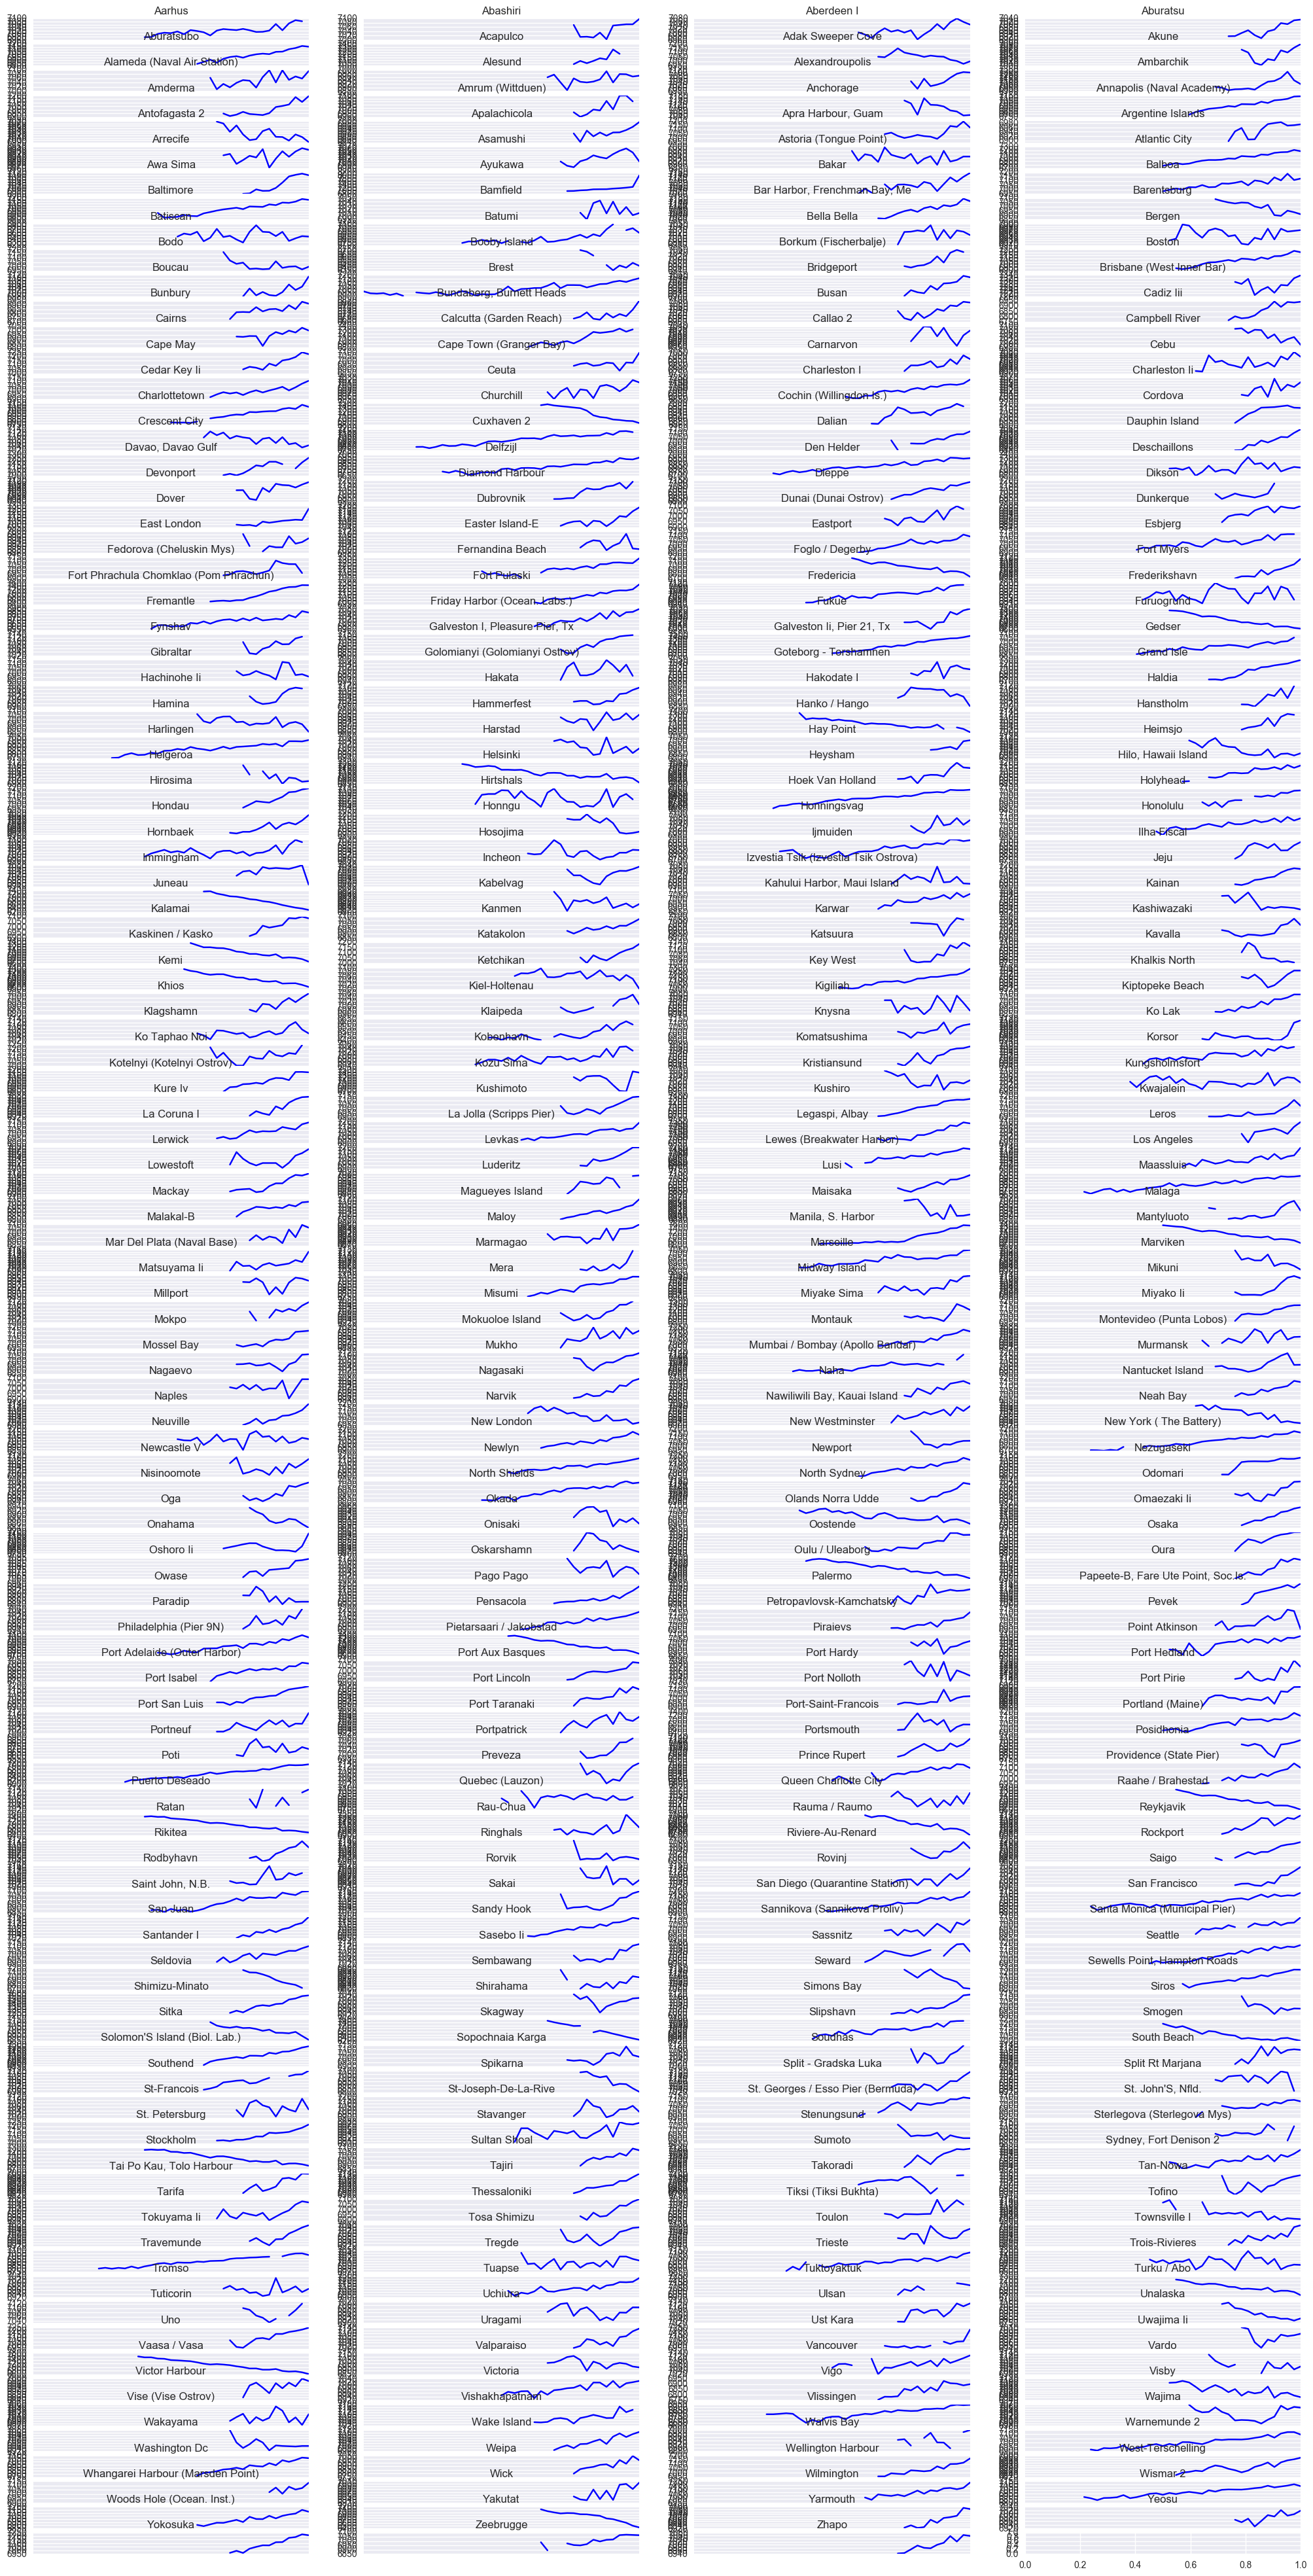

In [65]:
def plot_grid(df, cols=4, **kwargs):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / cols)), ncols=cols)
    fig.set_figheight(30)
    fig.set_figwidth(40)

    for i, x in enumerate(df.columns):
        ax = axes[i // cols, i % cols]
        df[x].plot(ax=ax, color='blue', legend=False, label=False,
                   kind='line', stacked=False, sharex=False,
                   figsize=(25, 50))
        ax.set_title(x)
        ax.xaxis.set_visible(False)
    return fig

fig = plot_grid(data_subset_plot)
fig.show()


# Iceland

In [66]:
data_ISL = df[(df.Country == 'ISL')].groupby(['Location', 'timestamp']).tide.mean().unstack().T
data_ISL.tail()

Location    Grindavik  Reykjavik
timestamp                       
2015-08-01        NaN     7125.0
2015-09-01        NaN     7085.0
2015-10-01        NaN     7176.0
2015-11-01        NaN     7221.0
2015-12-01        NaN     7264.0

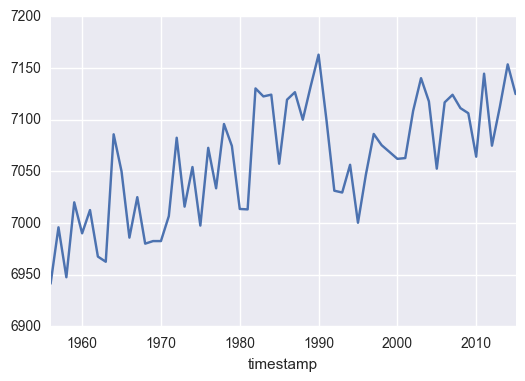

In [67]:
df[df.Location == 'Reykjavik'].set_index('timestamp').tide.resample('1A').mean().plot()

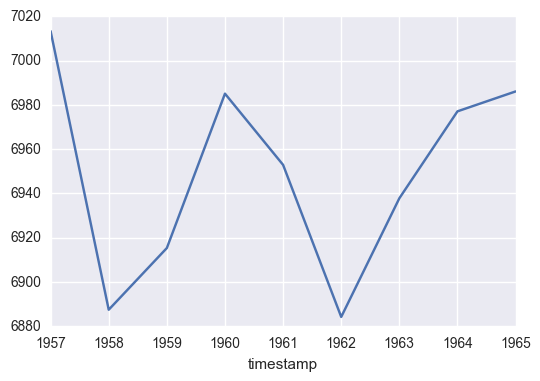

In [68]:
df[df.Location == 'Grindavik'].set_index('timestamp').tide.resample('1A').mean().plot()

# Philippines
26 tide gauges in the Philippines.

In [69]:
data_PHL = df[(df.Country == 'PHL')]

first_measurement_PHL = data_PHL.groupby(['Location']).timestamp.first()

first_measurement_PHL.sort_values()



Location
Manila, S. Harbor                1901-03-01
Cebu                             1935-05-01
Legaspi, Albay                   1947-05-01
Jolo, Sulu                       1947-11-01
Davao, Davao Gulf                1948-03-01
San Fernando, La Union           1948-04-01
Tacloban, Leyte                  1951-06-01
Port Irene                       1987-02-01
Surigao                          1987-05-01
San Jose                         1988-01-01
Puerto Princesa, Palawan         1990-07-01
Real Quezon                      2009-02-01
Balanacan, Marinduque            2011-01-01
Tandag, Surigao Del Sur          2011-01-01
Subic Zambales                   2011-01-01
Pulupandan, Negros Occidental    2011-01-01
Mati, Davao Oriental             2011-01-01
Virac, Catanduanes               2011-01-01
Mambajao Camguin                 2011-01-01
Makar, General Santos City       2011-01-01
Currimao Ilocos Norte            2011-01-01
Caticlan Malay Aklan             2011-01-01
Balintang, Quezon, Pala

timestamp
1951-12-31    6999.142857
1952-12-31    6995.700000
1953-12-31    6994.285714
1954-12-31    7058.272727
1955-12-31    7060.500000
Freq: A-DEC, Name: tide, dtype: float64

timestamp
1972-12-31    6983.666667
1973-12-31    6971.636364
1974-12-31    7040.666667
1975-12-31    7092.333333
1976-12-31    7027.333333
Freq: A-DEC, Name: tide, dtype: float64

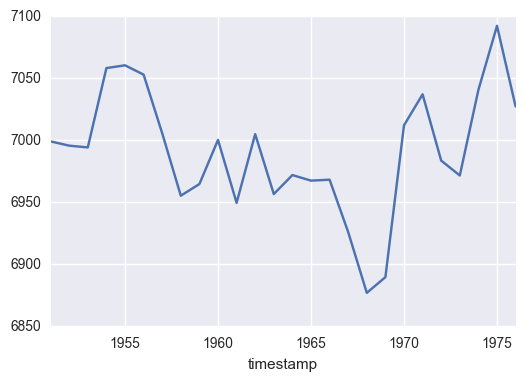

In [70]:
df[df.Location == 'Tacloban, Leyte'].set_index('timestamp').tide.resample('1A').mean().plot()
df[df.Location == 'Tacloban, Leyte'].set_index('timestamp').tide.resample('1A').mean().head()
df[df.Location == 'Tacloban, Leyte'].set_index('timestamp').tide.resample('1A').mean().tail()

In [71]:
data_PHL = df[(df.Country == 'PHL')].groupby(['Location', 'timestamp']).tide.mean().unstack().T

data_PHL = data_PHL.resample("1A").mean().apply(np.round)

data_PHL.tail()

Location    Balanacan, Marinduque  Balintang, Quezon, Palawan  \
timestamp                                                       
2010-12-31                    NaN                         NaN   
2011-12-31                 7029.0                      6990.0   
2012-12-31                 7064.0                      7009.0   
2013-12-31                 7050.0                         NaN   
2014-12-31                 6908.0                         NaN   

Location    Caticlan Malay Aklan    Cebu  Currimao Ilocos Norte  \
timestamp                                                         
2010-12-31                   NaN  7066.0                    NaN   
2011-12-31                6988.0  7081.0                 7018.0   
2012-12-31                7000.0  7114.0                 7116.0   
2013-12-31                6850.0  7082.0                 7107.0   
2014-12-31                6827.0  6914.0                 6931.0   

Location    Davao, Davao Gulf  Jolo, Sulu  Legaspi, Albay  \
timestamp                                                   
2010-12-31             7123.0         NaN          7283.0   
2011-12-31             7192.0         NaN          7345.0   
2012-12-31             7216.0         NaN          7385.0   
2013-12-31             7257.0         NaN          7365.0   
2014-12-31             7254.0         NaN          7268.0   

Location    Macabalan Port, Cagayan De Oro  Makar, General Santos City  \
timestamp                                                                
2010-12-31                             NaN                         NaN   
2011-12-31                          6940.0                      7006.0   
2012-12-31                          6962.0                      7059.0   
2013-12-31                          6981.0                      7098.0   
2014-12-31                          6935.0                      7041.0   

Location         ...        Pulupandan, Negros Occidental  Real Quezon  \
timestamp        ...                                                     
2010-12-31       ...                                  NaN       7100.0   
2011-12-31       ...                               6954.0       7108.0   
2012-12-31       ...                                  NaN       7187.0   
2013-12-31       ...                               6988.0       7136.0   
2014-12-31       ...                               6936.0       7164.0   

Location    San Fernando, La Union  San Jose  Subic Zambales  Surigao  \
timestamp                                                               
2010-12-31                     NaN    7078.0             NaN   7135.0   
2011-12-31                     NaN    7133.0          6954.0   7112.0   
2012-12-31                     NaN    7137.0          6979.0   7148.0   
2013-12-31                     NaN    7128.0          6820.0   7147.0   
2014-12-31                     NaN    7057.0          6799.0   7080.0   

Location    Tacloban, Leyte  Tandag, Surigao Del Sur  Virac, Catanduanes  \
timestamp                                                                  
2010-12-31              NaN                      NaN                 NaN   
2011-12-31              NaN                   6958.0              6990.0   
2012-12-31              NaN                   7068.0                 NaN   
2013-12-31              NaN                   7065.0              7159.0   
2014-12-31              NaN                   6934.0              7108.0   

Location    Zamboanga City  
timestamp                   
2010-12-31             NaN  
2011-12-31          7027.0  
2012-12-31          7055.0  
2013-12-31          7005.0  
2014-12-31          6896.0  

[5 rows x 26 columns]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


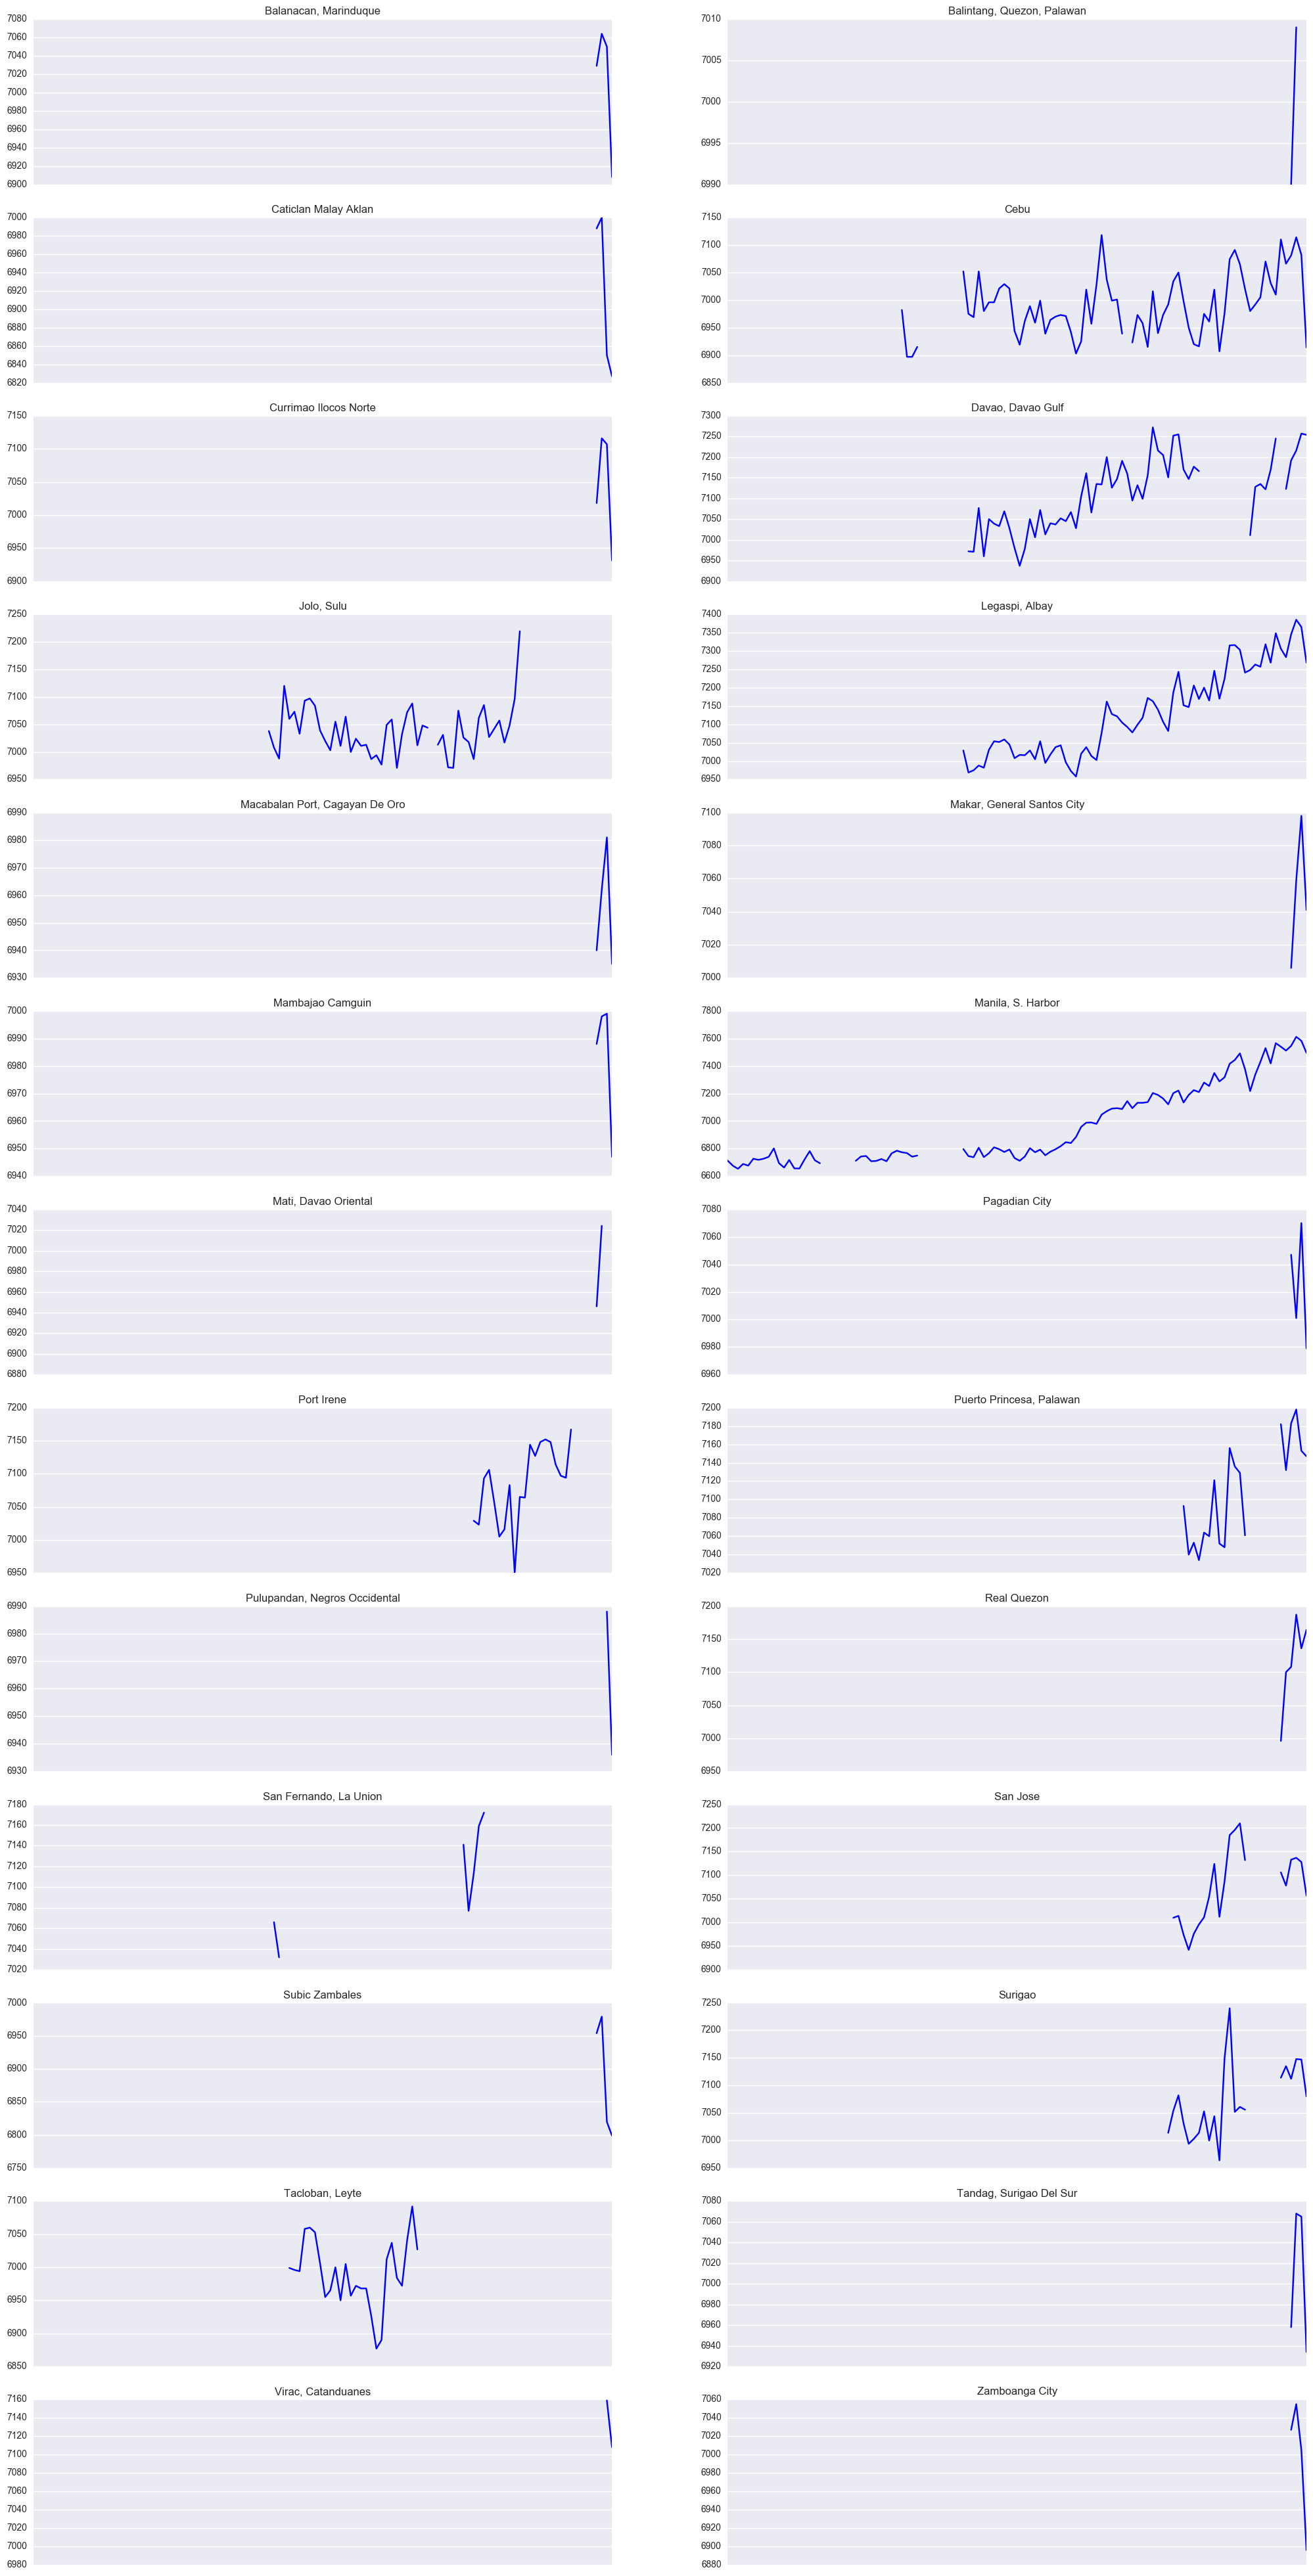

In [72]:
def plot_grid_small(df, cols=2, **kwargs):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / cols)), ncols=cols)
    fig.set_figheight(6)
    fig.set_figwidth(8)

    for i, x in enumerate(df.columns):
        ax = axes[i // cols, i % cols]
        df[x].plot(ax=ax, color='blue', legend=False, label=False,
                   kind='line', stacked=False, sharex=False,
                   figsize=(25, 50))
        ax.set_title(x)
        ax.xaxis.set_visible(False)
    return fig


fig = plot_grid_small(data_PHL)
fig.show()


## Export Datasets for Map Visualization

In [73]:
#Use trend data from PSMSL to filter dataset

trends_1961_2011 = pd.read_csv('data/psmsl_data/trends_1961_2011.csv', header=0, usecols=[0,1,2,3,4,7], names=['Location', 'Latitude', 'Longitude', 'Country', 'trend', 'ID']) 
trends_1985_2014 = pd.read_csv('data/psmsl_data/trends_1985_2014.csv', header=0, usecols=[4,7], names=['trend', 'ID'])


trends_1961_2011['Location'] = trends_1961_2011['Location'].apply(convert_location_names)
trends_1961_2011['Country'] = trends_1961_2011['Country'].apply(convert_location_names)

pd.qcut(trends_1961_2011['trend'], 5)
len(trends_1961_2011)

0         (1.364, 1.961]
1        (-0.185, 1.364]
2         (1.961, 2.951]
3         (1.364, 1.961]
4         (1.364, 1.961]
5         (1.364, 1.961]
6         (1.364, 1.961]
7         (2.951, 8.917]
8         (1.364, 1.961]
9      [-18.154, -0.185]
10        (1.364, 1.961]
11        (1.961, 2.951]
12        (1.364, 1.961]
13        (1.961, 2.951]
14        (1.364, 1.961]
15        (1.364, 1.961]
16     [-18.154, -0.185]
17        (2.951, 8.917]
18     [-18.154, -0.185]
19       (-0.185, 1.364]
20     [-18.154, -0.185]
21       (-0.185, 1.364]
22        (1.364, 1.961]
23     [-18.154, -0.185]
24        (1.961, 2.951]
25     [-18.154, -0.185]
26     [-18.154, -0.185]
27       (-0.185, 1.364]
28     [-18.154, -0.185]
29       (-0.185, 1.364]
30     [-18.154, -0.185]
31     [-18.154, -0.185]
32        (1.961, 2.951]
33        (1.364, 1.961]
34        (1.364, 1.961]
35     [-18.154, -0.185]
36       (-0.185, 1.364]
37       (-0.185, 1.364]
38        (1.364, 1.961]
39        (1.961, 2.951]


365

In [74]:
def yearly_mean(dataframe):
    
    mean_dataframe = dataframe.set_index('timestamp').tide.resample('1A').mean()
    mean_dataframe = mean_dataframe.reset_index()
    
    return pd.DataFrame(mean_dataframe)

def rolling_mean(dataframe):
    
    mean_dataframe = dataframe.set_index('timestamp').tide.resample('1A').mean()
    mean_dataframe = mean_dataframe.rolling(center=False, window=3, min_periods=1).mean()
    mean_dataframe = mean_dataframe.reset_index()
    
    return pd.DataFrame(mean_dataframe)


newdat = df.groupby(['ID']).apply(rolling_mean)

newdat.head()

timestamp         tide
ID                          
1  0 1807-12-31  6970.333333
   1 1808-12-31  6918.833333
   2 1809-12-31  6930.861111
   3 1810-12-31  6922.888889
   4 1811-12-31  6959.500000

In [76]:
#delete rows which are not used for visualization

data_subset_viz = df.drop(['missing day','flag for attention', 'GLOSS ID', 'Coastline', 'Flag', 'Station', 'Date'], 1)

data_subset_viz = data_subset_viz.groupby(['ID']).apply(yearly_mean)

data_subset_viz = data_subset_viz.reset_index()

#delete rows which are not used for visualization

data_subset_viz = data_subset_viz.drop(['level_1'], 1)

#filter by trend data
data_subset_viz = data_subset_viz.merge(trends_1961_2011, left_on='ID', right_on='ID')

#add worldbank data
data_subset_viz = data_subset_viz.merge(worldbank_data, left_on='ID', right_on='ID')

data_subset_viz.head()
data_subset_viz['ID'].nunique()

ID  timestamp         tide Location  Latitude  Longitude Country  trend  \
0   1 1807-12-31  6970.333333    Brest  48.38285  -4.494838  France  1.783   
1   1 1808-12-31  6867.333333    Brest  48.38285  -4.494838  France  1.783   
2   1 1809-12-31  6954.916667    Brest  48.38285  -4.494838  France  1.783   
3   1 1810-12-31  6946.416667    Brest  48.38285  -4.494838  France  1.783   
4   1 1811-12-31  6977.166667    Brest  48.38285  -4.494838  France  1.783   

   emission           gdp         pop  pop_sealevel ISO3-Code  
0  5.050483  2.421682e+12  66808385.0      2.892156       FRA  
1  5.050483  2.421682e+12  66808385.0      2.892156       FRA  
2  5.050483  2.421682e+12  66808385.0      2.892156       FRA  
3  5.050483  2.421682e+12  66808385.0      2.892156       FRA  
4  5.050483  2.421682e+12  66808385.0      2.892156       FRA

365

In [77]:
data_subset_viz = data_subset_viz.set_index(['timestamp'])

data_subset_viz = data_subset_viz.loc['1807-12-31':'2015-12-31']

data_subset_viz = data_subset_viz.reset_index()

#data_subset_viz.sort_values('timestamp', ascending=False)

data_subset_viz['ID'].nunique()

365

In [79]:
#function to use first tide measurement as zero reference point

def to_zero(dataframe):
    first_value = dataframe['tide'].iloc[0]
    dataframe['tide'] = dataframe['tide'] - first_value
    return dataframe

In [80]:
data_subset_viz = data_subset_viz.groupby(['ID']).apply(to_zero)
data_subset_viz['ID'].nunique()

365

In [84]:
j = (data_subset_viz.groupby(['ID','Location','Country','Latitude','Longitude', 'trend', 'emission', 'pop', 'pop_sealevel', 'gdp'], as_index=False)
       .apply(lambda x: x[['timestamp','tide']].to_dict('r'))
       .reset_index()
       .rename(columns={0:'tideData'})
       .to_json(orient='records', date_format='iso'))

with open('data/subsets/subset.json', 'w') as fp:
    json.dump(json.loads(j), fp, indent=2, sort_keys=True)

print(json.dumps(json.loads(j), indent=2, sort_keys=True))

[
  {
    "Country": "France",
    "ID": 1,
    "Latitude": 48.38285,
    "Location": "Brest",
    "Longitude": -4.494838,
    "emission": 5.0504829944,
    "gdp": 2421682377730.0,
    "pop": 66808385.0,
    "pop_sealevel": 2.892155592,
    "tideData": [
      {
        "tide": 0.0,
        "timestamp": "1807-12-31T00:00:00.000Z"
      },
      {
        "tide": -103.0,
        "timestamp": "1808-12-31T00:00:00.000Z"
      },
      {
        "tide": -15.4166666667,
        "timestamp": "1809-12-31T00:00:00.000Z"
      },
      {
        "tide": -23.9166666667,
        "timestamp": "1810-12-31T00:00:00.000Z"
      },
      {
        "tide": 6.8333333333,
        "timestamp": "1811-12-31T00:00:00.000Z"
      },
      {
        "tide": 2.5833333333,
        "timestamp": "1812-12-31T00:00:00.000Z"
      },
      {
        "tide": -45.4166666667,
        "timestamp": "1813-12-31T00:00:00.000Z"
      },
      {
        "tide": -28.5,
        "timestamp": "1814-12-31T00:00:00.000Z"
      },
 

### Create subsets for countries

In [34]:
def save_country_subset(df, country):
    filename = 'data/sealevel_subset_' + str(country) + '.csv'
    data = df[(df.Country == country)]
    data.to_csv(filename, encoding='utf-8')
    return data

df_est = save_country_subset(df, 'EST')

df_est.tail()

tide  missing day flag for attention  timestamp   ID Location  \
101391  6831.0          0.0                000 1938-08-01  321  Tallinn   
101392  6928.0          0.0                000 1938-09-01  321  Tallinn   
101393  7058.0          0.0                000 1938-10-01  321  Tallinn   
101394  7170.0          0.0                000 1938-11-01  321  Tallinn   
101395  6776.0          0.0                000 1938-12-01  321  Tallinn   

        Latitude  Longitude  GLOSS ID Country        Date  Coastline  Station  \
101391     59.45       24.8       NaN     EST  01/01/1980         82       11   
101392     59.45       24.8       NaN     EST  01/01/1980         82       11   
101393     59.45       24.8       NaN     EST  01/01/1980         82       11   
101394     59.45       24.8       NaN     EST  01/01/1980         82       11   
101395     59.45       24.8       NaN     EST  01/01/1980         82       11   

       Flag  
101391    N  
101392    N  
101393    N  
101394    N  
101395    N

In [35]:
def count_positives(df):
    counter = 0
    for index, row in df.iterrows():
        if row['trend'] < 0:
            counter += 1
    return counter